# Plot WOCE Transects

This notebook is based on a script provided by Chris Chapman to plot WOCE transects from ACCESS-OM2 runs, and to compare with observations (gridded WOA13).

### Important Notes
* Running this script at 0.1° requires quite a bit of memory -- I used 24 workers and a full 48-core node on Gadi to run this.
* The figures produced here are not verbatim identical to the ones published in the paper, because we have used a slightly different method to incorporate WOA13 transects into the bias plots. But they are very close ...

In [1]:
import intake
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client, progress

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40963,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:34423,Total threads: 1
Dashboard: /proxy/44511/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:35129,


Open ACCESS-NRI's default catalog:

In [3]:
catalog = intake.cat.access_nri

Define start and end times for the WOA13 period:

In [4]:
start_time = '1985-01-01'
end_time = '2013-12-31'

Make a dictionary with transect information:

In [5]:
transect_dict = {"SR3": {"lon": -220,
                         "lon_label":140,
                         "lat_bounds": [-67, -42],
                         "temp_range": [-2, 13]},
                 "P16": {"lon": -150,
                         "lon_label": -150,
                         "lat_bounds": [-76,61],
                         "temp_range": [-2, 28]},
                 "A16": {"lon": -25,
                         "lon_label": -25,
                         "lat_bounds": [-75.01,70],
                         "temp_range": [-2, 28]},
                 "I08-09": {"lon": -265,
                            "lon_label": 95,
                            "lat_bounds": [-65,15.1],
                            "temp_range": [-2, 28]}
                }

In [6]:
def load_temp_salt(res):
    
    if res == '1deg':
        expt = '1deg_jra55_iaf_omip2_cycle5'
        ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/10_KDS50/woa13_ts_??_mom10.nc',chunks={'ZT': None,'GRID_X_T':5})
    if res == '025deg':
        expt = '025deg_jra55_iaf_omip2_cycle5'
        ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/025_KDS50/woa13_ts_??_mom025.nc',chunks={'ZT': None,'GRID_X_T':5})
    if res == '01deg':
        expt = '01deg_jra55v140_iaf_cycle4'
        ds_obs = xr.open_mfdataset('/g/data/ik11/observations/woa13/01/woa13_ts_??_mom01.nc',chunks={'ZT': None,'GRID_X_T':5})
        
    ds = catalog[expt].search(
        variable = ['temp', 'salt'],
        frequency = '1mon',
        variable_cell_methods = 'time: mean'
    ).to_dataset_dict()

    ds = xr.merge(ds.values()).chunk({'time':'auto'})
    ds = ds.sel(time = slice(start_time, end_time)).mean('time')
    ds['temp'] = ds['temp'] - 273.15

    ds_obs = ds_obs.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
    ds_obs['xt_ocean'] = ds['xt_ocean'].values
    ds_obs['yt_ocean'] = ds['yt_ocean'].values
    ds_obs['st_ocean'] = ds['st_ocean'].values
    ds_obs = ds_obs.mean('time')
    
    model_cross_sections = {}
    obs_cross_sections = {}
    for cs in list(transect_dict.keys()):
        lon = transect_dict[cs]['lon']
        lat = [transect_dict[cs]['lat_bounds'][0], transect_dict[cs]['lat_bounds'][1]]
        model_cross_sections[cs] = ds.sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = slice(lat[0], lat[1])).load()
        obs_cross_sections[cs] = ds_obs.sel(xt_ocean = lon, method = 'nearest').sel(yt_ocean = slice(lat[0], lat[1])).load()
        obs_cross_sections[cs] = xr.where(np.isnan(model_cross_sections[cs]), np.nan, obs_cross_sections[cs])
        print('Loaded '+cs)
        
    return model_cross_sections, obs_cross_sections

In [7]:
ts_mod = {}; ts_obs = {}
ts_mod['1deg'], ts_obs['1deg'] = load_temp_salt('1deg')
ts_mod['025deg'], ts_obs['025deg'] = load_temp_salt('025deg')
ts_mod['01deg'], ts_obs['01deg'] = load_temp_salt('01deg')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


Loaded SR3
Loaded P16
Loaded A16
Loaded I08-09

--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


Loaded SR3
Loaded P16
Loaded A16
Loaded I08-09

--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


Loaded SR3
Loaded P16
Loaded A16
Loaded I08-09


In [8]:
labels  = ['(a) ACCESS-OM2','(b) ACCESS-OM2','(c) ACCESS-OM2-025','(d) ACCESS-OM2-025','(e) ACCESS-OM2-01', '(f) ACCESS-OM2-01','(g) WOA13','(h) WOA13']

In [9]:
xticks = np.arange(-75,75.1,15)
xtick_labels = []
for i_tick in range(xticks.size):
    if xticks[i_tick]<0:
        xtick_labels.append(str(int(abs(xticks[i_tick]))) + r'$^{\circ}$S')
    elif xticks[i_tick]>0:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$N')
    else:
        xtick_labels.append(str(int(xticks[i_tick])) + r'$^{\circ}$')

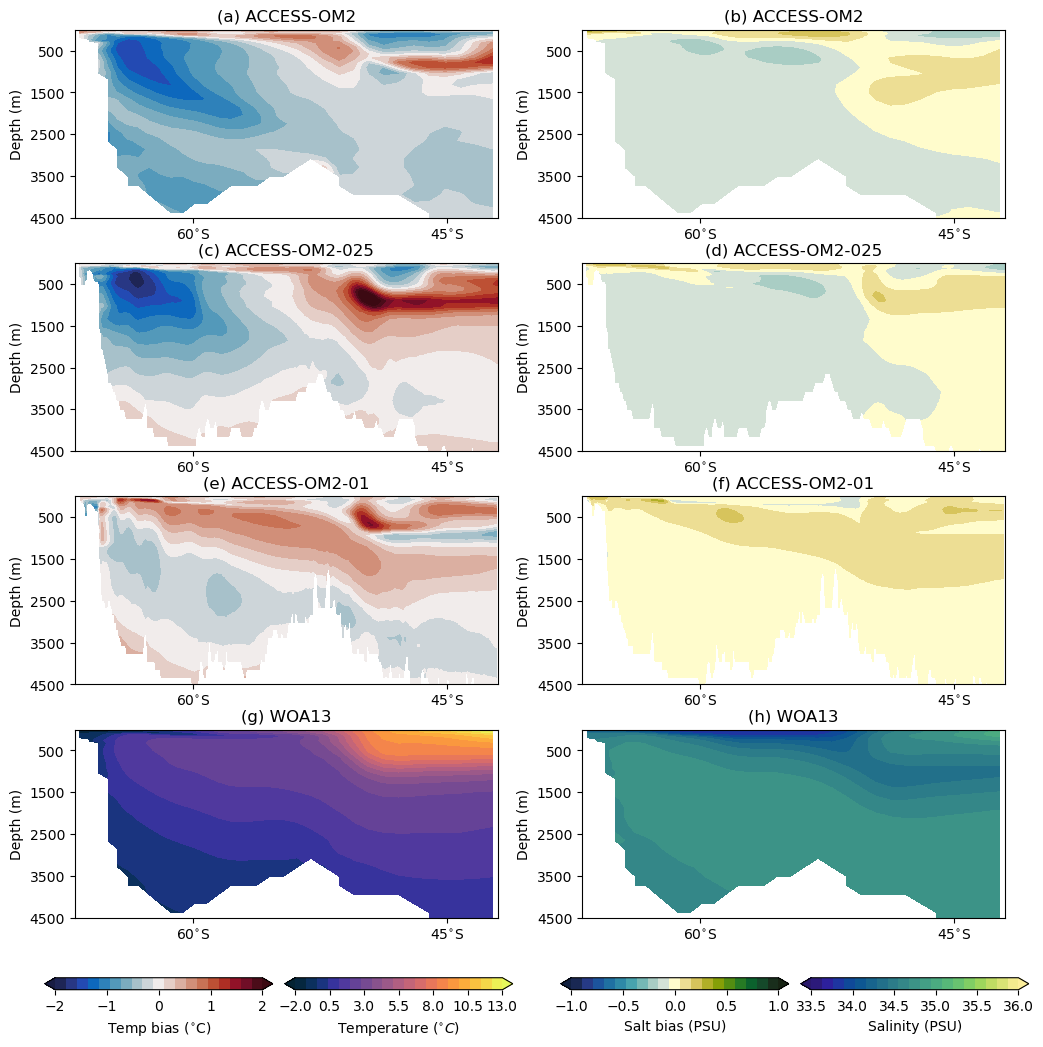

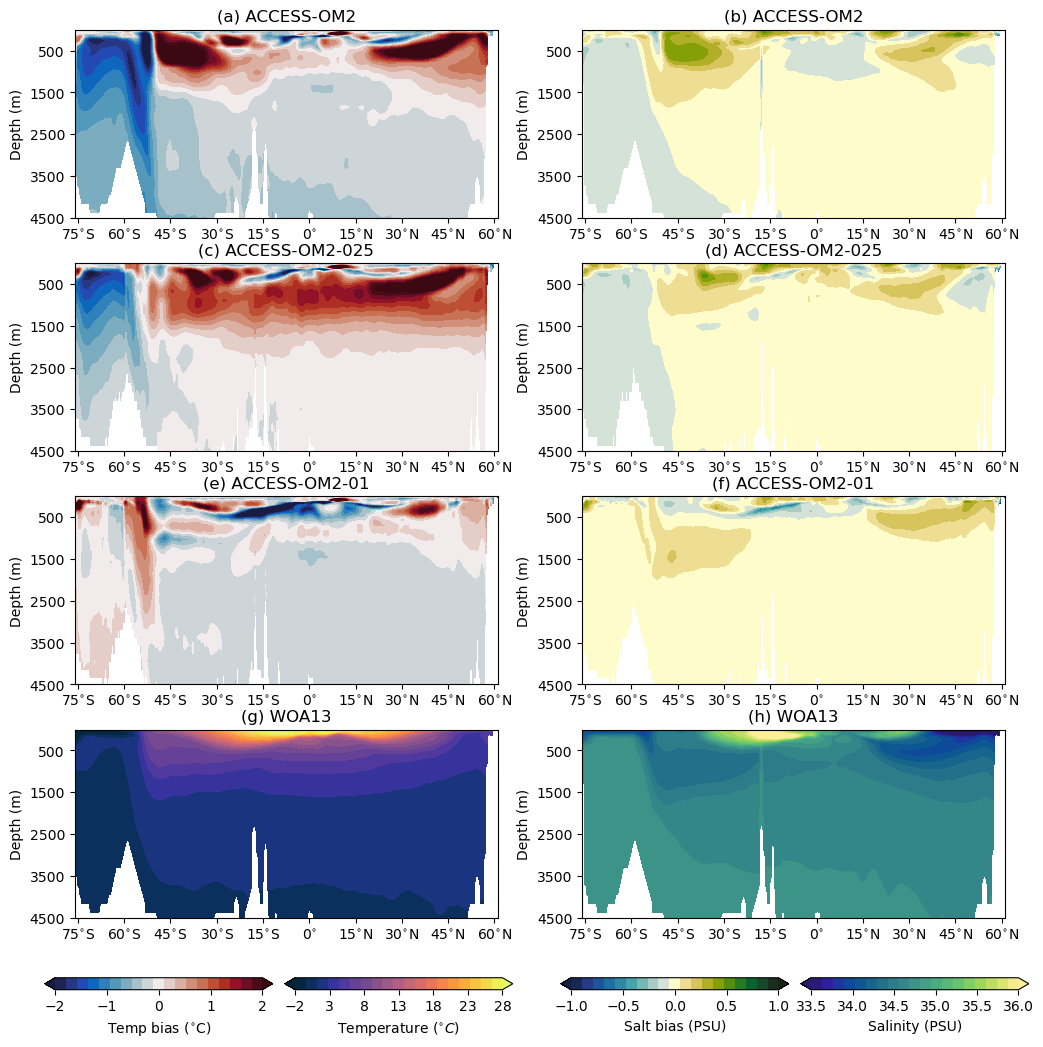

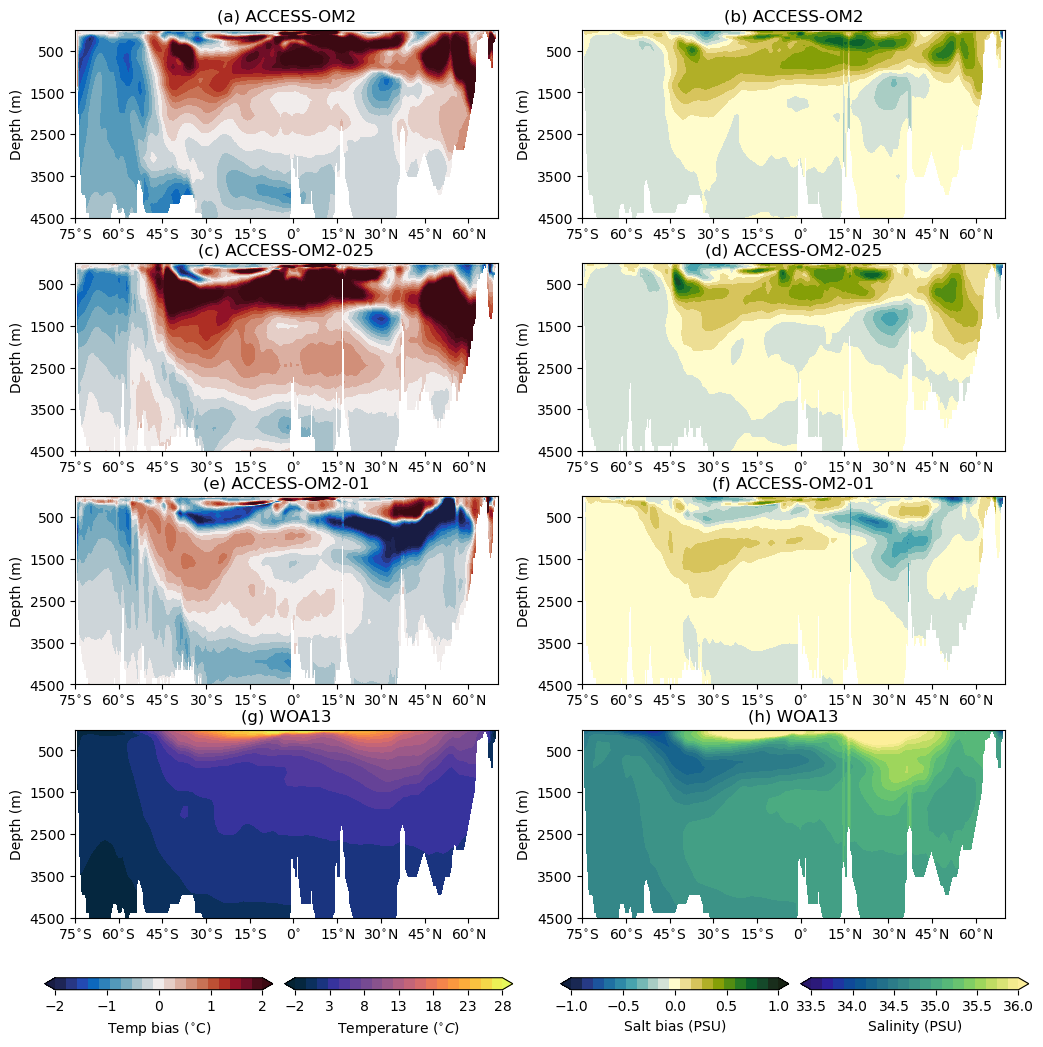

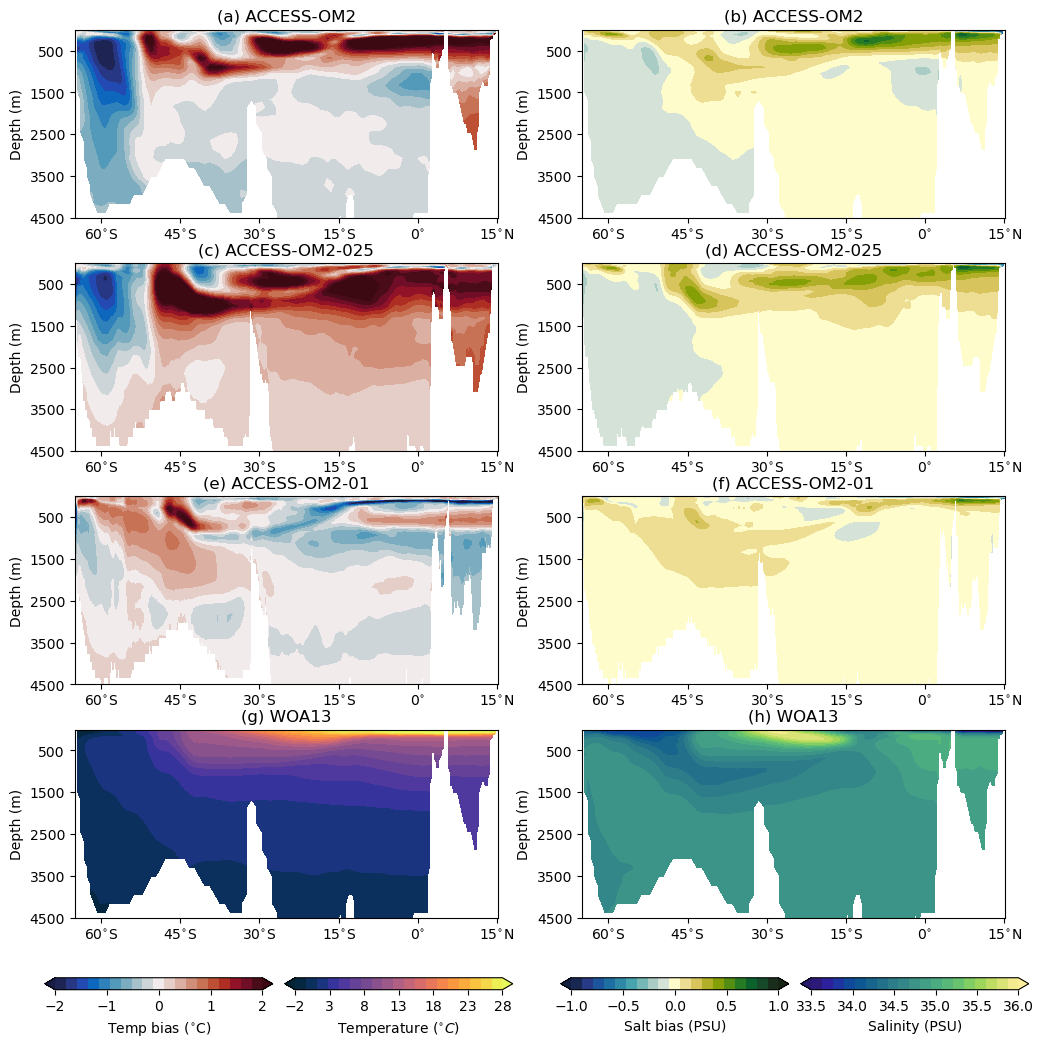

In [13]:
n = 0
for transect in list(transect_dict.keys()):
    
    transect_lon_label  = transect_dict[transect]['lon_label']

    main_label    = r'Transect ' + transect + str(transect_lon_label)
    
    #===============================================#
    # Plot Temperature & Salinity Sections
    #===============================================#

    fig = plt.figure(figsize=(12,12))
    plt.subplots_adjust(bottom=0.14,hspace=0.24)    

    ax1 = fig.add_subplot(4,2,1)
    cs_temp = ax1.contourf(ts_mod['1deg'][transect]['yt_ocean'], -ts_mod['1deg'][transect]['st_ocean'], 
                          ts_mod['1deg'][transect]['temp'] - ts_obs['1deg'][transect]['temp'],
                          levels = np.linspace(-2, 2, 20), extend = 'both', cmap = cm.cm.balance)
    ax2 = fig.add_subplot(4,2,3)
    cs_temp = ax2.contourf(ts_mod['025deg'][transect]['yt_ocean'], -ts_mod['025deg'][transect]['st_ocean'], 
                          ts_mod['025deg'][transect]['temp'] - ts_obs['025deg'][transect]['temp'],
                          levels = np.linspace(-2, 2, 20), extend = 'both', cmap = cm.cm.balance)
    ax3 = fig.add_subplot(4,2,5)
    cs_temp = ax3.contourf(ts_mod['01deg'][transect]['yt_ocean'], -ts_mod['01deg'][transect]['st_ocean'], 
                          ts_mod['01deg'][transect]['temp'] - ts_obs['01deg'][transect]['temp'],
                          levels = np.linspace(-2, 2, 20), extend = 'both', cmap = cm.cm.balance)

    cbax1 = plt.axes([0.1,0.08,0.19,0.01])
    cbar = fig.colorbar(cs_temp, cax = cbax1, orientation = 'horizontal',
                        ticks = np.linspace(-2,2,5))
    cbar.set_label('Temp bias ($^{\circ}$C)')
    
    ax4 = fig.add_subplot(4,2,7)
    cs_temp = ax4.contourf(ts_mod['1deg'][transect]['yt_ocean'], -ts_mod['1deg'][transect]['st_ocean'], 
                          ts_obs['1deg'][transect]['temp'],
                          levels = np.linspace(transect_dict[transect]['temp_range'][0], transect_dict[transect]['temp_range'][1], 20), 
                          extend = 'both', cmap = cm.cm.thermal)
    
    cbax2 = plt.axes([0.3,0.08,0.19,0.01])
    cbar = fig.colorbar(cs_temp, cax = cbax2, orientation = 'horizontal', 
                        ticks = np.linspace(transect_dict[transect]['temp_range'][0], transect_dict[transect]['temp_range'][1], 7))
    cbar.set_label('Temperature ($^{\circ}C$)')
    
    ax5 = fig.add_subplot(4,2,2)
    cs_salt = ax5.contourf(ts_mod['1deg'][transect]['yt_ocean'], -ts_mod['1deg'][transect]['st_ocean'], 
                          ts_mod['1deg'][transect]['salt'] - ts_obs['1deg'][transect]['salt'],
                          levels = np.linspace(-1, 1, 20), extend = 'both', cmap = cm.cm.delta)
    ax6 = fig.add_subplot(4,2,4)
    cs_salt = ax6.contourf(ts_mod['025deg'][transect]['yt_ocean'], -ts_mod['025deg'][transect]['st_ocean'], 
                          ts_mod['025deg'][transect]['salt'] - ts_obs['025deg'][transect]['salt'],
                          levels = np.linspace(-1, 1, 20), extend = 'both', cmap = cm.cm.delta)
    
    cbax3 = plt.axes([0.53,0.08,0.19,0.01])
    cbar = fig.colorbar(cs_salt, cax = cbax3, orientation = 'horizontal',
                        ticks = np.linspace(-1,1,5))
    cbar.set_label('Salt bias (PSU)')
    
    ax7 = fig.add_subplot(4,2,6)
    cs_salt = ax7.contourf(ts_mod['01deg'][transect]['yt_ocean'], -ts_mod['01deg'][transect]['st_ocean'], 
                          ts_mod['01deg'][transect]['salt'] - ts_obs['01deg'][transect]['salt'],
                          levels = np.linspace(-1, 1, 20), extend = 'both', cmap = cm.cm.delta)

    ax8 = fig.add_subplot(4,2,8)
    cs_salt = ax8.contourf(ts_mod['1deg'][transect]['yt_ocean'], -ts_mod['1deg'][transect]['st_ocean'], 
                          ts_obs['1deg'][transect]['salt'],
                          levels = np.linspace(33.5, 36, 20), 
                          extend = 'both', cmap = cm.cm.haline)

    cbax4 = plt.axes([0.73,0.08,0.19,0.01])
    cbar = fig.colorbar(cs_salt, cax = cbax4, orientation = 'horizontal',
                        ticks = np.linspace(33.5,36,6))
    cbar.set_label('Salinity (PSU)')
    
    i = 0
    for ax in [ax1, ax5, ax2, ax6, ax3, ax7, ax4, ax8]:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xlim(transect_dict[transect]['lat_bounds'])
 
        ax.set_yticks(np.arange(-4500,0.1,1000))
        ax.set_yticklabels(np.arange(4500,0.1,-1000).astype(int))
        ax.set_ylim([-4500,0])
        ax.set_ylabel(r"Depth (m)") 
        ax.set_title(labels[i]); i+=1
        
    n += 1